# Pricing Zero-Coupon Treasury Bills Using NPV
In this example, we will compute the price of zero-coupon United States Treasury Bills, or __T-bills__ using the Net Present Value (NPV) approach.

__Learning Objectives:__ After completing this example, you should be able to:
1. **Price zero-coupon T-bills** using the Net Present Value (NPV) approach with discount rates
2. **Understand the inverse relationship** between T-bill prices and yields (Malkiel's Theorem 1)
3. **Interpret cash flow structures** for zero-coupon securities
4. **Compare computed prices** with market auction prices and analyze discrepancies

__What we'll do:__ We've downloaded a dataset of T-bill auction data (approximately 100 T-bills with different maturities) from 2025. We will use the discount rate (in this context called the investment rate) from the dataset to compute the auction price of the T-bill, and then we'll compare our computed price with the actual auction price.

Let's get started!
___

## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. 

> The [include(...) function](https://docs.julialang.org/en/v1/base/base/#include) is a convenient way to load Julia code from another file. The `Include.jl` file is a Julia file that loads external packages, and various functions that we will use in the exercise. It checks for a `Manifest.toml` file; if it finds one, packages are loaded. Otherwise, packages are downloaded and then loaded.

In [1]:
include(joinpath(@__DIR__, "Include.jl")); # this sets up the environment, we'll do this all the time, on everything we do

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We'll explore `T-bill` prices from United States Treasury auctions between May and August of 2025 downloaded as a `CSV` file using the [Auction query functionality of TreasuryDirect.gov](https://www.treasurydirect.gov/auctions/auction-query/). 

We load the `CSV` dataset using a [local `MyTreasuryBillDataSet()` function](src/Files.jl), which returns the auction data as [a `DataFrame` instance](https://dataframes.juliadata.org/stable/). We store the data in the `data::DataFrame` variable.

In [2]:
dataset = MyTreasuryBillDataSet()

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,Investment Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64
1,912797QW0,Bill,4-Week,08/28/2025,09/02/2025,09/30/2025,99.6698,0.04318
2,912797RE9,Bill,8-Week,08/28/2025,09/02/2025,10/28/2025,99.3552,0.0423
3,912797RZ2,Bill,17-Week,08/27/2025,09/02/2025,12/30/2025,98.6712,0.04131
4,912797QE0,Bill,6-Week,08/26/2025,08/28/2025,10/09/2025,99.5088,0.0429
5,912797NL7,Bill,13-Week,08/25/2025,08/28/2025,11/28/2025,98.9522,0.04201
6,912797RU3,Bill,26-Week,08/25/2025,08/28/2025,02/26/2026,98.0208,0.0405
7,912797QV2,Bill,4-Week,08/21/2025,08/26/2025,09/23/2025,99.6656,0.04374
8,912797RD1,Bill,8-Week,08/21/2025,08/26/2025,10/21/2025,99.3436,0.04307
9,912797RY5,Bill,17-Week,08/20/2025,08/26/2025,12/23/2025,98.6612,0.04162


Next, let's store the dimension (number of records) of our treasury auction dataset in the `number_of_bills::Int64` variable using [the `nrow(...)` function exported by the DataFrames.jl package](https://dataframes.juliadata.org/stable/lib/functions/#DataAPI.nrow):

In [3]:
number_of_bills = nrow(dataset)

96

___

## Task 1: Compute the Price of Zero-Coupon Treasury Bills at Auction
We compute the T-bill price by building a discounting model in this task. In this case, let's construct an instance of the [`DiscreteCompoundingModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.DiscreteCompoundingModel) and store this discount model in the `discount_model` variable.

> The [`DiscreteCompoundingModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.DiscreteCompoundingModel) has no data associated with it. Instead, it is used [by the Julia multiple dispatch system](https://docs.julialang.org/en/v1/manual/methods/#Methods) so that we call the correct pricing methods later.

Let's build our discount model:

In [4]:
discount_model = DiscreteCompoundingModel();

Next, let's build a zero-coupon Treasury bill model, an instance of [the `MyUSTreasuryZeroCouponBondModel` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.MyUSTreasuryZeroCouponBondModel) using [a custom `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.build-Tuple{Type{MyUSTreasuryZeroCouponBondModel},%20NamedTuple}). 

> The [`build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.build-Tuple{Type{MyUSTreasuryZeroCouponBondModel},%20NamedTuple}) requires two arguments: the type of thing we want to build, and [a NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) holding data needed to construct the thing we want to build. In this case, we pass the `par` value of the T-bill and the `n` argument, i.e., the number of compounding periods per year. 

Let's build out the zero-coupon model. Store the zero-coupon model in the `model::MyUSTreasuryZeroCouponBondModel` variable.

In [5]:
model = build(MyUSTreasuryZeroCouponBondModel, (
    par = 100.0, n = 2
));

We can use [the `typeof(...)` function](https://docs.julialang.org/en/v1/base/base/#Core.typeof) in combination with [the `fieldnames(...)` function](https://docs.julialang.org/en/v1/base/base/#Base.fieldnames) to inspect the structure of our model, i.e., what data the model holds:

In [6]:
typeof(model) |> T -> fieldnames(T)

(:par, :rate, :T, :price, :n, :cashflow, :discount)

The zero-coupon instance is missing some critical data, so let's manually add this to the `model` instance and then compute the price. We'll select an example T-bill from the `dataset::DataFrame`

> __What is going on?__ We compute the price of the T-bill using the [Julia pipe `|>` operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) in combination with the discounting model [using a short-cut syntax](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#Short-cut-syntax).

Compute the price at auction $V_{B}$:

In [7]:
model.T = "26-Week"  |> securityterm; # parameters for T-bill #6
model.rate = 0.0405; # parameters for T-bill # 6
model |> discount_model

MyUSTreasuryZeroCouponBondModel(100.0, 0.0405, 0.4986301369863014, 98.02057600598177, 2, Dict(0 => -98.02057600598177, 1 => 100.0), Dict(0 => 1.0, 1 => 1.0201939641111417))

Did we get the same price as that recorded at auction?

> __Idea:__ If two values are within some relative tolerance `rtol` of each other, the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) returns `true`; otherwise, it returns `false`. When the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) is combined with the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert), a `false` result generates an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError). Thus, we have a simple test for equality that works well for floating-point numbers.

So, how did we do?

In [8]:
let
    auction_price = dataset[6, :Price];
    computed_price = model.price
    @assert isapprox(auction_price, computed_price; rtol=1e-4)
end

### Batch Pricing: Compute Prices for All T-bills
Finally, we compute the zero-coupon T-bill price for all the T-bills in `dataset` and compare the computed price to the price observed at auction. We process each record in the `dataset::DataFrame` using [a `for-loop`](https://docs.julialang.org/en/v1/base/base/#for). During each iteration of the loop:

> __Each iteration:__ We get data from the `dataset::DataFrame` and update the T-bill model instance. In particular, we set the observed price to the variable `auction_price,` we set the duration `T` field (which we convert to the number of years using the local `securityterm` function) and the rate field on the `model::MyUSTreasuryZeroCouponBondModel` instance, and then we compute the price.

We calculate the percentage error between the estimated and observed T-bill price and store the simulation data for each iteration in the `computed_price_table::DataFrame` using [the `push!(...)` function](https://dataframes.juliadata.org/stable/lib/functions/#Base.push!)

In [ ]:
let 

    # Initialize a fresh model for each T-bill calculation
    model = build(MyUSTreasuryZeroCouponBondModel, (
        par = 100.0, n = 2
    ));
    
    computed_price_table = DataFrame();
    for i ∈ 1:number_of_bills
        
        # Extract market data for this T-bill
        auction_price = dataset[i, :Price];  # Actual auction price from market
        
        # Set model parameters from dataset
        model.T = dataset[i, Symbol("Security Term")] |> String |> securityterm; # Convert term to years
        model.rate = dataset[i, Symbol("Investment Rate")];  # Discount rate for pricing
            
        # Compute theoretical price using NPV approach
        price_computed = model |> discount_model |> x-> x.price; 
        
        # Calculate pricing error as relative tolerance
        absrtol = abs((auction_price - price_computed)/(price_computed)); 
        
        # Store results for analysis
        results_tuple = (
            CUSIP = dataset[i, :CUSIP],
            term = dataset[i, Symbol("Security Term")],
            rate = (dataset[i, Symbol("Investment Rate")] |> x-> 100*x),  # Convert to percentage
            computed =  price_computed |> x-> round(x, digits=3),
            actual = auction_price |> x-> round(x, digits=3),
            rtol = absrtol
        );
        push!(computed_price_table, results_tuple)
    end
    pretty_table(computed_price_table, tf=tf_simple)
end

============ ========= ========= ========== ========= ==============
      CUSIP      term      rate   computed    actual          rtol 
   String15   String7   Float64    Float64   Float64       Float64 
============ ========= ========= ========== ========= ==============
  912797QW0    4-Week     4.318     99.673     99.67     2.9945e-5
  912797RE9    8-Week      4.23      99.36    99.355    4.64703e-5
  912797RZ2   17-Week     4.131     98.676    98.671    4.64237e-5
  912797QE0    6-Week      4.29     99.513    99.509    3.95309e-5
  912797NL7   13-Week     4.201     98.969    98.952   0.000167802
  912797RU3   26-Week      4.05     98.021    98.021    1.77508e-6
  912797QV2    4-Week     4.374     99.669    99.666    3.08123e-5
  912797RD1    8-Week     4.307     99.348    99.344    4.82259e-5
  912797RY5   17-Week     4.162     98.666    98.661    4.79185e-5
  912797MS3    6-Week     4.325     99.509    99.505    4.11384e-5
  912797QR1   13-Week     4.232     98.961    98.956    

___

## Task 2: Compute the T-bill price versus the interest rate
Malkiel proposed five theorems that govern the price of fixed-income debt securities, e.g., [Treasury Bills, Notes, and Bonds](https://www.treasurydirect.gov/marketable-securities/), as a function of duration and interest rate values:
* [Malkiel, B. G. (1962). Expectations, Bond Prices, and the Term Structure of Interest Rates. The Quarterly Journal of Economics, 76(2), 197–218](https://www.jstor.org/stable/1880816)

The first of these theorems is that T-bill/note/bond prices are inversely proportional to the yield (the investment rate for T-bills):
> __Theorem 1__: Bond prices move inversely to bond yields.

Malkiel proved Theorem 1 analytically (and we'll do the same next time). However, now, let's test this relationship computationally. 

First, select a random bill from the `dataset::DataFrame` by selecting an index from `1...number_of_bills` using [the built-in Julia `rand(...)` function](https://docs.julialang.org/en/v1/stdlib/Random/#Base.rand). We'll use this T-bill as our example to test __Theorem 1.__

In [10]:
random_bill_index = rand(1:number_of_bills)
println("Selected bill: $(random_bill_index)")

Selected bill: 76


What is the data for our test T-bill?

In [11]:
dataset[random_bill_index,:] # what is the auction data for this bill?

Row,CUSIP,Security Type,Security Term,Auction Date,Issue Date,Maturity Date,Price,Investment Rate
,String15,String7,String7,String15,String15,String15,Float64,Float64
76,912797PW1,Bill,13-Week,06/09/2025,06/12/2025,09/11/2025,98.9257,0.04356


Next, create an instance of [the `MyUSTreasuryZeroCouponBondModel` model](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.MyUSTreasuryZeroCouponBondModel) from the randomly selected nominal auction data using [the `build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.build-Tuple{Type{MyUSTreasuryZeroCouponBondModel},%20NamedTuple}), assuming a par value of `100 USD` with two compounding periods per year. These values will be passed as arguments to the [`build(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/fixed/#VLQuantitativeFinancePackage.build-Tuple{Type{MyUSTreasuryZeroCouponBondModel},%20NamedTuple}) in the `par` and `n` parameters. 

Update the rest of the parameters on the `zero_coupon_model` instance from the `dataset`. The resulting zero-coupon model will be stored in the `model::MyUSTreasuryZeroCouponBondModel` variable.

See the [DataFrames.jl documentation for examples of accessing data from a `DataFrame` instance](https://dataframes.juliadata.org/stable/man/basics/). 

In [12]:
zero_coupon_model = build(MyUSTreasuryZeroCouponBondModel, (
    par = 100.0, n = 2, 
    T = dataset[random_bill_index, Symbol("Security Term")] |> String |> securityterm,
    rate =  dataset[random_bill_index, Symbol("Investment Rate")]
)) |> discount_model; 

#### Check: Is the computed price _similar_ to the auction price $V_{B}$?
The [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) checks the equality of numerical values up to some tolerance value, where either relative `rtol` or absolute tolerance `atol` can be specified. Let's use relative tolerance. 

> __Idea:__ If two values are within `rtol` of each other, the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) returns `true`; otherwise, it returns `false`. When the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox) is combined with the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert), a `false` result generates an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError). Thus, we have a simple test for equality that works well for floating-point numbers.

So, how did we do?

In [13]:
auction_price = dataset[random_bill_index, :Price];
computed_price = zero_coupon_model.price
@assert isapprox(auction_price, computed_price; rtol=1e-4)

#### Can we see the cash flow events?
The cash flow events for the T-bill are stored in the `cashflow::Dict{Int64, Float64}` dictionary of the zero-coupon model. For a zero-coupon T-bill, there are only two cash flows:

>__Zero-coupon cash flows:__ An initial investment (negative $V_{B}$ cash flow at time `0`), and the payoff of par value $V_{P}$ (positive cash flow) at maturity (at time `1`).

Let's take a look at them.

In [14]:
zero_coupon_model.cashflow

Dict{Int64, Float64} with 2 entries:
  0 => -98.9314
  1 => 100.0

### Interest Rate Perturbation Setup
To simulate the impact of changes in the interest rate, let's perturb the effective nominal interest rate $\bar{r}$, with all other values held constant, i.e., generate a new rate of the form $\bar{r}\leftarrow\beta\cdot\bar{r}$, where $\beta$ is a perturbation value; if $\beta<1$ the perturbed interest rate is _less than_ the nominal rate, if $\beta=1$ the perturbed interest rate is _equal to_ the nominal rate, and if $\beta>1$ the perturbed interest rate is _greater than_ the nominal rate.

* First, we specify the number of perturbation values we want to consider; we store this value in the `number_of_samples` variable. If `number_of_samples` is odd, the perturbation range will include the nominal interest rate as the center value.
* Next, we specify the lower and upper values of the perturbation range; the lower bound is stored in the `β₁` variable, while the upper bound is stored in the `β₂` variable.
* Finally, we compute the perturbation array (stored in the `β`-variable) using the [range function](https://docs.julialang.org/en/v1/base/math/#Base.range) in combination with the [Julia pipe |> operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping), and [the Julia collect function](https://docs.julialang.org/en/v1/base/collections/#Base.collect-Tuple{Type,%20Any}), which converts a range type to a collection, i.e., an array

In [15]:
number_of_samples = 7;
β₁ = 0.8;
β₂ = 1.2;
β = range(β₁, stop = β₂, length = number_of_samples) |> collect;

### Theorem 1 Simulation: Price vs. Interest Rate
Compute the price of the selected T-bill using different values for the effective interest rate and store the results in the `theorem_1_simulation_array` variable. Iterate through each value of the $\beta$ array using a for loop, where we use the [eachindex function](https://docs.julialang.org/en/v1/base/arrays/#Base.eachindex). 

For iteration $i$ of the loop:
* Get a value for the perturbation $\beta_{i}$ from the $\beta$-array, and compute the new effective interest rate $\bar{r} \gets \beta_{i}\cdot{\bar{r}}$.
* Update the `zero_coupon_model` instance with the new rate (set the `rate` field), and compute the new price
* Store the $\beta_{i}$ value in column 1 and the percentage difference in price in column 2 of the `theorem_1_simulation_array`
* Store the new value of the effective interest rate and the new price in columns 3 and 4, respectively. 

In [16]:
theorem_1_simulation_array = let

    # Initialize results matrix: [β_value, %_change, new_rate, new_price]
    theorem_1_simulation_array = Array{Float64,2}(undef, number_of_samples, 4);
    
    # Test Malkiel's Theorem 1 by perturbing interest rates
    for i ∈ eachindex(β)
        
        # Get perturbation factor for this iteration
        β_value = β[i];
        
        # Calculate new interest rate: r̄_new = β * r̄_original
        r̄ = dataset[random_bill_index, Symbol("Investment Rate")];  # Original rate
        r̄_value = β_value * r̄;  # Perturbed rate
        
        # Update model with new rate and compute price
        zero_coupon_model.rate = r̄_value;
        tmp = zero_coupon_model |> discount_model;
        new_price = tmp.price;
        
        # Store results for analysis
        theorem_1_simulation_array[i,1] = β_value;  # Perturbation factor
        theorem_1_simulation_array[i,2] = ((new_price - computed_price)/(computed_price))*100;  # % price change
        theorem_1_simulation_array[i,3] = r̄_value;  # New interest rate
        theorem_1_simulation_array[i,4] = new_price;  # New price
    end
    theorem_1_simulation_array;
end

7×4 Matrix{Float64}:
 0.8        0.213255   0.034848  99.1424
 0.866667   0.142018   0.037752  99.0719
 0.933333   0.0709334  0.040656  99.0016
 1.0        0.0        0.04356   98.9314
 1.06667   -0.0707825  0.046464  98.8614
 1.13333   -0.141415   0.049368  98.7915
 1.2       -0.211897   0.052272  98.7218

### Visualize the perturbation $\beta$ versus the %-change in price
`Unhide` the code block below to see how we plotted the percentage change in the T-bill price versus the $\beta$-parameter (a surrogate for the effective interest rate). The case of $\beta = 1$ denotes the nominal interest rate, $\beta<1$ denotes decreased interest rates compared to the nominal value, and $\beta>1$ denotes an increased interest rate.
> __Summary__: The price of the T-bill appears to be inversely proportional to the $\beta$-parameter, i.e., the effective interest rate of the instrument. Thus, we appear to confirm `Theorem 1` by simulation.

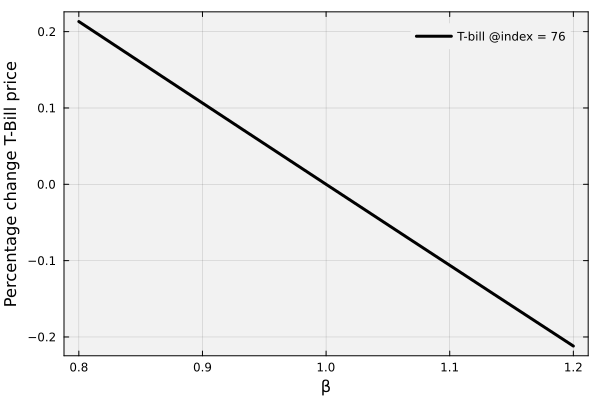

In [17]:
let
    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    plot(q, theorem_1_simulation_array[:,1], theorem_1_simulation_array[:,2], lw=3, c=:black, xlabel="β", 
            ylabel="Percentage change T-Bill price", label="T-bill @index = $(random_bill_index)")
end

### Discussion: Is the slope of the interest rate versus the price line negative?
If the relationship between the price and the yield is inversely proportional, then the slope of price versus $\bar{r}$ should be negative; let's check this condition by computing the slope from the simulation array, store this in the `slope` variable.

> __Idea:__ Use the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to test if the slope is negative: if $\text{slope}>0$, i.e., `Theorem 1` is not supported, this test will throw an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError), otherwise the `Theorem 1` is supported by simulation

What do we see?

In [18]:
slope = (theorem_1_simulation_array[end,4] - theorem_1_simulation_array[1,4])/(theorem_1_simulation_array[end,3] - theorem_1_simulation_array[1,3]);
@assert (slope < 0.0)  # Verify Theorem 1: negative slope confirms inverse price-yield relationship

___

## Summary
In this example, we demonstrated:

1. **NPV Pricing**: How to price zero-coupon T-bills using the Net Present Value approach with discount rates
2. **Market Comparison**: Computed prices closely match actual auction prices [from TreasuryDirect.gov](https://www.treasurydirect.gov)
3. **Theorem Validation**: Computational verification of Malkiel's Theorem 1 showing the inverse relationship between bill prices and interest rates
4. **Cash Flow Analysis**: Understanding the simple two-cash-flow structure of zero-coupon securities
5. **Sensitivity Analysis**: How T-bill prices respond to changes in interest rates through perturbation analysis

The notebook combines theoretical financial concepts with practical Julia programming, providing both educational value and computational tools for fixed-income analysis.
___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.

___